In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [2]:
data = pd.read_csv("mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
data.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [4]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [5]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
types = np.unique(np.array(df['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [7]:
total = df.groupby(['type']).count()
total

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


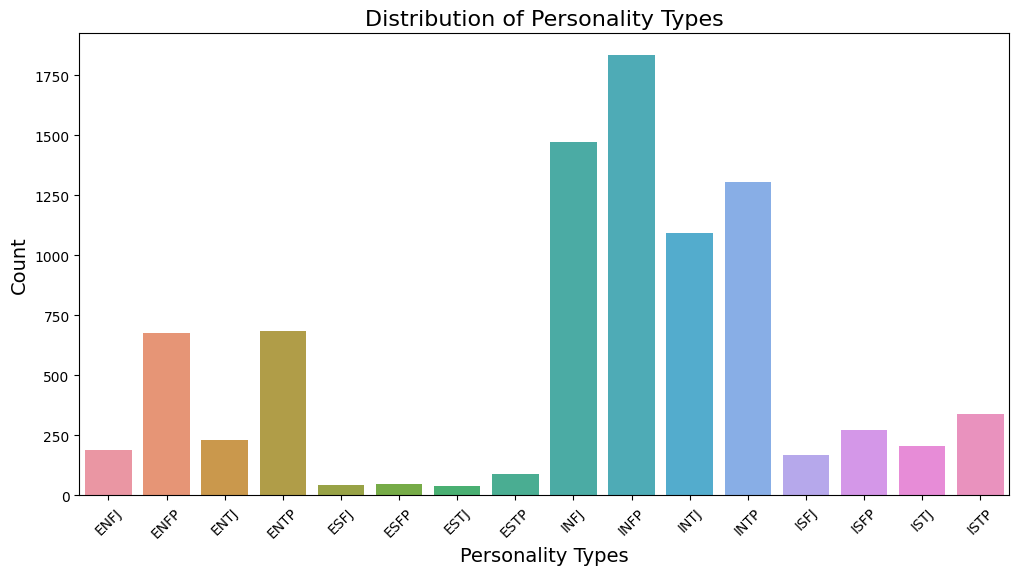

In [8]:
# Assuming 'total' DataFrame contains personality type counts
plt.figure(figsize=(12, 6))
sns.barplot(x=total.index, y=total['posts'])
plt.xlabel('Personality Types', size=14)
plt.ylabel('Count', size=14)
plt.title('Distribution of Personality Types', size=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

output_folder = 'static'
output_path = os.path.join(output_folder, 'Distribution_Types.png')
plt.savefig(output_path)
plt.show()


In [26]:
import os
import plotly.express as px


fig = px.pie(total, values='posts', names=total.index, title='Distribution of Personality Types',
             color_discrete_sequence=px.colors.qualitative.Pastel, hole=0.4,
             hover_data=['posts'], custom_data=['posts'])

fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0), 
    font=dict(size=12),
)

output_path = os.path.join(output_folder, 'personalities.html')

fig.write_html(output_path, include_plotlyjs='cdn')


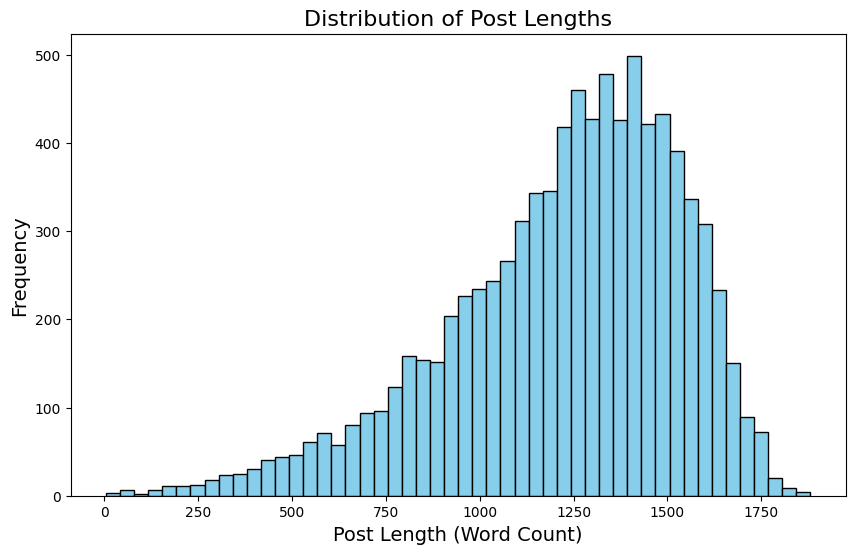

In [10]:


df['post_length'] = df['posts'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['post_length'], bins=50, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Post Length (Word Count)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Post Lengths', size=16)

output_path = os.path.join(output_folder, 'post_length.png')
plt.savefig(output_path)
plt.show()

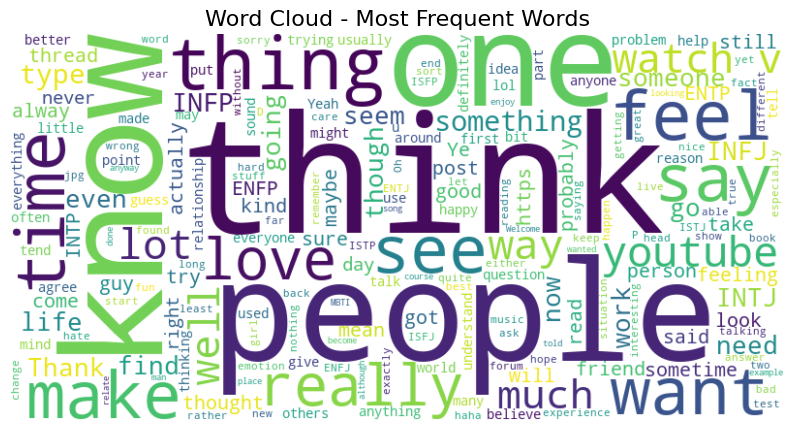

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text = ' '.join(df['posts'])  


wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud - Most Frequent Words', size=16)


output_path = os.path.join(output_folder, 'Word_Cloud.png')
plt.savefig(output_path)
plt.show()

In [12]:
text = df.iloc[0:3].copy()
text

,type,posts,post_length
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,556
1,ENTP,'I'm finding the lack of me in these posts ver...,1170
2,INTP,'Good one _____ https://www.youtube.com/wat...,836


In [13]:
def split_text(text):
    return text.strip("'").split('|||')

In [14]:
df['posts'] = df['posts'].str.lower()
df

,type,posts,post_length
0,INFJ,'http://www.youtube.com/watch?v=qsxhcwe3krw|||...,556
1,ENTP,'i'm finding the lack of me in these posts ver...,1170
2,INTP,'good one _____ https://www.youtube.com/wat...,836
3,INTJ,"'dear intp, i enjoyed our conversation the o...",1064
4,ENTJ,'you're fired.|||that's another silly misconce...,967
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edhb_h908||...,796
8671,ENFP,'so...if this thread already exists someplace ...,1309
8672,INTP,'so many questions when i do these things. i ...,948
8673,INFP,'i am very conflicted right now when it comes ...,1705


In [15]:
df['posts'] = df['posts'].apply(split_text)
df

,type,posts,post_length
0,INFJ,"[http://www.youtube.com/watch?v=qsxhcwe3krw, h...",556
1,ENTP,[i'm finding the lack of me in these posts ver...,1170
2,INTP,[good one _____ https://www.youtube.com/wat...,836
3,INTJ,"[dear intp, i enjoyed our conversation the o...",1064
4,ENTJ,"[you're fired., that's another silly misconcep...",967
...,...,...,...
8670,ISFP,"[https://www.youtube.com/watch?v=t8edhb_h908, ...",796
8671,ENFP,[so...if this thread already exists someplace ...,1309
8672,INTP,[so many questions when i do these things. i ...,948
8673,INFP,[i am very conflicted right now when it comes ...,1705


In [16]:
def join_strings(string_list, separator=' '):
    return separator.join(string_list)

# Convert 'posts' column to text
df['posts'] = df['posts'].apply(join_strings)
df

,type,posts,post_length
0,INFJ,http://www.youtube.com/watch?v=qsxhcwe3krw htt...,556
1,ENTP,i'm finding the lack of me in these posts very...,1170
2,INTP,good one _____ https://www.youtube.com/watc...,836
3,INTJ,"dear intp, i enjoyed our conversation the ot...",1064
4,ENTJ,you're fired. that's another silly misconcepti...,967
...,...,...,...
8670,ISFP,https://www.youtube.com/watch?v=t8edhb_h908 ix...,796
8671,ENFP,so...if this thread already exists someplace e...,1309
8672,INTP,so many questions when i do these things. i w...,948
8673,INFP,i am very conflicted right now when it comes t...,1705


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\altie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

def preprocess_text(text):
 
    text = re.sub(r'(http|https|www)\S+', 'link', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    processed_text = ' '.join(stemmed_tokens)
    
    return processed_text

In [19]:
df['posts'] = df['posts'].apply(preprocess_text)
df

,type,posts,post_length
0,INFJ,link link enfp intj moment link sportscent top...,556
1,ENTP,'m find lack post alarm . sex bore 's posit of...,1170
2,INTP,"good one _____ link cours , say know ; 's bles...",836
3,INTJ,"dear intp , enjoy convers day . esoter gab nat...",1064
4,ENTJ,'re fire . 's anoth silli misconcept . approac...,967
...,...,...,...
8670,ISFP,link ixfp alway think cat fi dom reason . link...,796
8671,ENFP,... thread alreadi exist someplac els ( : link...,1309
8672,INTP,mani question thing . would take purpl pill . ...,948
8673,INFP,conflict right come want children . honestli m...,1705


In [20]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['posts'])

feature_names = tfidf_vectorizer.get_feature_names_out() 

In [21]:
features_df = tfidf_matrix.toarray()
features_df

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04544078, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
new_df = pd.DataFrame()
new_df['type'] = enc.fit_transform(df['type'])

target = new_df['type'] 
target

0        8
1        3
2       11
3       10
4        2
        ..
8670    13
8671     1
8672    11
8673     9
8674     9
Name: type, Length: 8675, dtype: int32

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.33, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

MemoryError: Unable to allocate 1.82 GiB for an array with shape (2863, 85509) and data type float64

In [ ]:
accuracies = {}

random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 38.04%


In [ ]:
import joblib

joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']